In [0]:
import warnings
warnings.filterwarnings('ignore')

# Multilabel prediction with Amazon planet dataset

In [0]:
import fastai as f
import fastai.vision as fv

# 1. Dataset Collection
- We will download the dataset from kaggle 

In [3]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
!mkdir .kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eabdul","key":"3e1b089e057c5ddc020433ea61bf8d11"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
path = fv.Config.data_path()/'planet'

In [0]:
path.mkdir(parents=True, exist_ok=True)

In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}

 99% 597M/600M [00:08<00:00, 101MB/s]
100% 600M/600M [00:08<00:00, 78.1MB/s]


In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}

 97% 582M/603M [00:06<00:00, 146MB/s]
100% 603M/603M [00:06<00:00, 92.0MB/s]


In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}

 97% 294M/304M [00:03<00:00, 115MB/s]
100% 304M/304M [00:03<00:00, 91.7MB/s]


In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 59.1MB/s]


In [0]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f sample_submission_v2.csv -p {path}  

  0% 0.00/154k [00:00<?, ?B/s]
100% 154k/154k [00:00<00:00, 47.3MB/s]


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [0]:
! unzip -q -n {path}/sample_submission_v2.csv.zip -d {path}

# 2. Data Preparation

In [0]:
train_df = fv.pd.read_csv(path/'train_v2.csv')
sample_df = fv.pd.read_csv(path/'sample_submission_v2.csv')

In [0]:
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
sample_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


### Data Block API

In [0]:
tfms = fv.get_transforms(flip_vert=True, max_warp=0.)

In [0]:
fv.np.random.seed(42)
train_src = (fv.ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (train_src.transform(tfms, size=256).databunch().normalize(fv.imagenet_stats))

In [0]:
data.train_ds[0]

(Image (3, 256, 256), MultiCategory haze;primary)

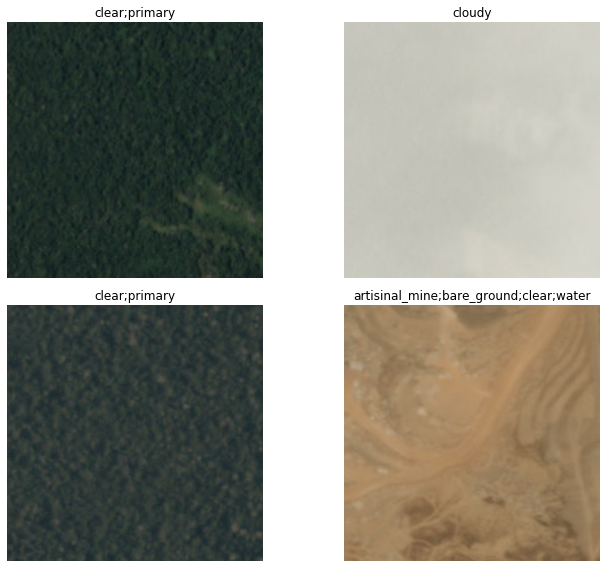

In [0]:
data.show_batch(rows=2, figsize=(10, 8))

In [0]:
arch = fv.models.resnet50

In [0]:
arch_2 = fv.models.densenet121

In [0]:
# partial function creates the partial function on the top of existing functions(passed as arguement in the partial function)
acc = fv.partial(fv.accuracy_thresh, thresh=0.2)
f = fv.partial(fv.fbeta, thresh=0.2) # f2_score will be evaluated in the contest

In [0]:
resnet = fv.create_cnn(data, arch, metrics=[acc, f])

In [0]:
densenet = fv.create_cnn(data, arch_2, metrics=[acc, f])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 53.7MB/s]


In [0]:
resnet.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


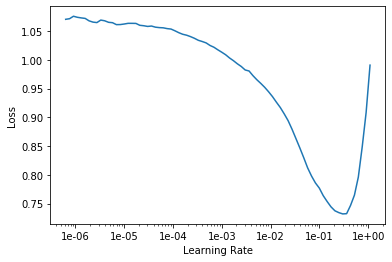

In [0]:
resnet.recorder.plot()

In [0]:
densenet.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


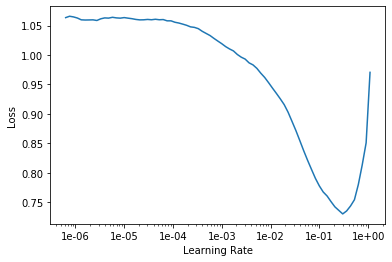

In [0]:
densenet.recorder.plot()

In [0]:
densenet.fit_one_cycle(5, slice(1e-01))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.160780,0.184227,0.926600,0.872040,12:12
1,0.186251,0.206523,0.951037,0.890910,12:02
2,0.137354,0.113306,0.944047,0.906249,11:58
3,0.112518,0.260909,0.956153,0.917948,11:57
4,0.095238,0.414827,0.955710,0.923592,11:58


In [0]:
densenet.fit_one_cycle(5, slice(1e-01))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.146657,0.732645,0.941605,0.884353,11:58
1,0.168991,1.690928,0.954787,0.894818,11:57
2,0.138370,0.385537,0.948436,0.903027,11:56
3,0.106650,0.136356,0.958427,0.920252,11:55
4,0.095072,0.110316,0.956872,0.925578,11:55
